In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import h5py, os, sys

import pycbc
from pycbc.types.timeseries import TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter.resample import resample_to_delta_t
from pycbc.events import ThresholdCluster
from pycbc.filter import matched_filter, resample_to_delta_t, highpass_fir
from pycbc.vetoes import power_chisq
from pycbc.filter.matchedfilter import sigma
from pycbc.events.ranking import newsnr

from scipy.signal.windows import tukey

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

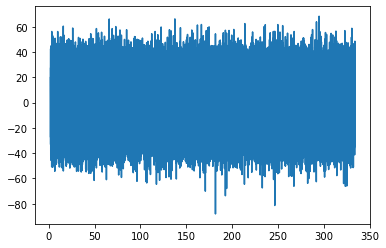

In [4]:
flow = 20
fhigh = 200
order = 512

strain = resample_to_delta_t(TimeSeries(np.array(h5py.File('Lstrain.hdf5', 'r')['strain']['Strain']), delta_t=1/4096), 1/512).time_slice(410,750)
strain = strain.highpass_fir(flow, order).lowpass_fir(fhigh, order)

strain.start_time = 0
strain.whiten(4,4).plot()

In [14]:
temp_hdf = h5py.File('linS.hdf5', 'r')
M = temp_hdf.attrs['M']
r = temp_hdf.attrs['ri']
Q = temp_hdf.attrs['Qi']
ids = temp_hdf.attrs['id']


In [15]:
ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [5]:
def SNR(Temp, Strain, time=50, nbins=26, crop = 5, ret='reg'):
    
    
    strain = Strain.copy()
    temp = Temp.copy()
        
    ## if time is none, then template is not injected
    if time is not None:
        temp.start_time=time
        strain = strain.inject(temp)
        temp.start_time=0
    
    
    PSD = interpolate(strain.psd(4), strain.delta_f)
    PSD = inverse_spectrum_truncation(PSD, int(4 * strain.sample_rate), trunc_method='hann')
    #################################################
    
    temlen = temp.duration
    temp.resize(len(strain))
    temp = temp.cyclic_time_shift(strain.duration-temlen/2)
    
    snr = abs(matched_filter(temp, strain, psd=PSD, low_frequency_cutoff=flow, high_frequency_cutoff=fhigh))   
    
    if ret != 'reg':
        
        chisq = power_chisq(temp, strain, 26, PSD, low_frequency_cutoff=flow, high_frequency_cutoff=fhigh, return_bins=False)/(26*2-2)
        
        snr = TimeSeries(newsnr(snr, chisq), delta_t=1/512)
    return snr.crop(5,5)

In [6]:
def horizon(temp, strain, lims = (7.95, 8.05)):
    
    tslice = (50,60)
    i = 0 # initial distance (source and detector)
    itt = 2 # will itterate as 10**(itt) or 1/10**(itt)

    # check if Dh = 6 (1 Mpc) is alreadt the horizon distance for this template
    snr = max(SNR(temp, strain).time_slice(tslice[0], tslice[1]))
    
    if snr > lims[0] and snr < lims[1]:
        return i
    
    # if snr is lower than 7.5, then keep reducing the lumin Distance by 10**2. When the snr crosses 8.5, then lower the itterator by half.
    # At that point, function will reduce the Lumin Distance by 10**1 instead of 10**2. When SNR is finally between 7.5 and 8.5, the loop stops.
    if snr < lims[0]:
        keep = True
        while keep:
            i -= itt
        
            snr = max(SNR(temp/10**i, strain).time_slice(tslice[0], tslice[1]))
        
            if snr > lims[1]:
                i += itt
                itt /= 2
        
            if snr > lims[0] and snr < lims[1]:
                keep = False
            
                return i
    
    # same if the snr is more than 8.5. Here the Lumin Distance is increased instead of decreased.
    if snr > lims[1]:
        keep = True
        while keep:
            i += itt
        
            snr = max(SNR(temp/10**i, strain).time_slice(tslice[0], tslice[1]))
        
            if snr < lims[0]:
                i -= itt
                itt /= 2
        
            if snr > lims[0] and snr < lims[1]:
                keep = False
            
                return i

In [23]:
from tqdm import tqdm

cols = ['Id', 'M', 'ri', 'Qi', 'Dh', 'snr', 'newsnr']
df = pd.DataFrame(columns=cols)



for i, z in zip(range(len(ids)), tqdm(range(len(ids)))):
               
    temp = TimeSeries(np.array(temp_hdf['Hp'][str(ids[i])]), delta_t=1/512)
    temp = temp.highpass_fir(flow, order).lowpass_fir(fhigh, order)

    Dh = horizon(temp, strain)
    
    temp = temp/(10**Dh)
    
    snr = max(SNR(temp, strain).time_slice(57, 59))
    nsnr = max(SNR(temp, strain, ret='new').time_slice(57, 59))
    
    key = pd.DataFrame([[ids[i], M[i], r[i], Q[i], Dh, snr, nsnr]], columns=cols)
    df = pd.concat([df, key], ignore_index=True)
    


 99%|████████████████████████████████████████▋| 149/150 [03:26<00:01,  1.39s/it]


In [24]:
df

,Id,M,ri,Qi,Dh,snr,newsnr
0,0,1,1.0,-8.0,1.500000,7.962752,7.748144
1,1,1,2.0,-8.0,0.937500,8.030486,7.550456
2,2,1,3.0,-8.0,0.320312,8.004233,7.687770
3,3,1,4.0,-8.0,-0.574219,8.013345,7.990753
4,4,1,5.0,-8.0,-1.808594,8.018858,7.439480
...,...,...,...,...,...,...,...
145,145,50,2.0,-5.0,-3.742188,7.956060,7.751384
146,146,50,3.0,-5.0,-4.093750,7.993670,7.820711
147,147,50,4.0,-5.0,-4.347656,8.028932,7.798853
148,148,50,5.0,-5.0,-4.539062,7.998509,7.701314


In [25]:
df.to_csv('Horizon_Distances.csv')

In [2]:
df = pd.read_csv('Horizon_Distances.csv')

In [5]:
df['Dh'] = 10**df['Dh']

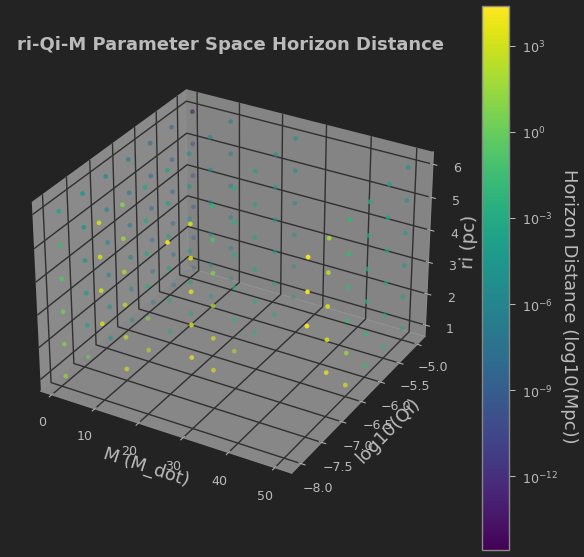

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

DF = df.copy()

p = ax.scatter(DF['M'], DF['Qi'], DF['ri'], c=DF['Dh'], norm=matplotlib.colors.LogNorm(vmin=DF['Dh'].min(), vmax=DF['Dh'].max()))
cbar = fig.colorbar(p, ax=ax)

cbar.set_label('Horizon Distance (log10(Mpc))', fontsize=18, rotation=270,labelpad=20, y=0.45)

ax.set_zlabel('ri (pc)', fontsize=18)
ax.set_ylabel('log10(Qi)', fontsize=18)
ax.set_xlabel('M (M_dot)', fontsize=18)
ax.set_title('ri-Qi-M Parameter Space Horizon Distance', fontsize=18, fontweight='bold')
plt.show()

In [24]:
def minDh(Dh):
    if Dh > 2/1000:
        return True
    else:
        return False

df['valid'] = df['Dh'].apply(minDh)

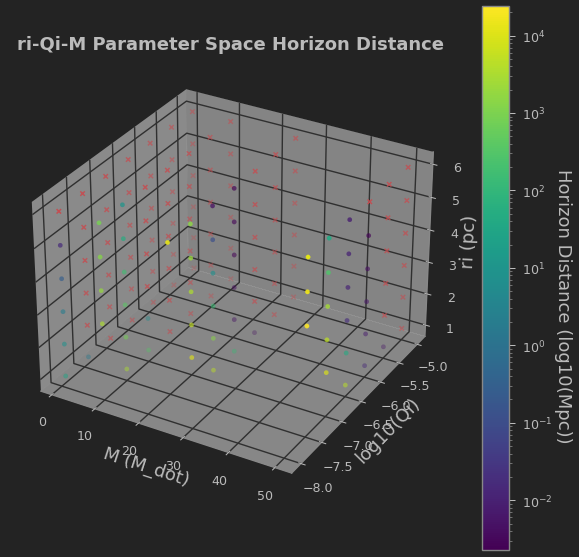

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

DF = df[df['valid']].copy()

p = ax.scatter(DF['M'], DF['Qi'], DF['ri'], c=DF['Dh'], norm=matplotlib.colors.LogNorm(vmin=DF['Dh'].min(), vmax=DF['Dh'].max()))
cbar = fig.colorbar(p, ax=ax)

cbar.set_label('Horizon Distance (log10(Mpc))', fontsize=18, rotation=270,labelpad=20, y=0.45)

DF = df[df['valid'] == False].copy()

ax.scatter(DF['M'], DF['Qi'], DF['ri'], c='r', marker='x')


ax.set_zlabel('ri (pc)', fontsize=18)
ax.set_ylabel('log10(Qi)', fontsize=18)
ax.set_xlabel('M (M_dot)', fontsize=18)
ax.set_title('ri-Qi-M Parameter Space Horizon Distance', fontsize=18, fontweight='bold')

plt.show()

In [26]:
df[df['valid']].shape[0]

57

In [27]:
2/1000

0.002